In [1]:
import numpy as np

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regular as regular

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk

from pprint import pprint

# from axon import loads, dumps
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: mlgrad.risk.Functional size changed, may indicate binary incompatibility. Expected 456 from C header, got 472 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: mlgrad.risk.SimpleFunctional size changed, may indicate binary incompatibility. Expected 456 from C header, got 472 from PyObject
  return f(*args, **kwds)


In [2]:
X, Y = load_boston(True)
print(X.shape)
#Is = [i for i,y in enumerate(Y) if y < 50.0]

#X = X[Is]
#Y = Y[Is]
    
#print(X.shape)

scaler = MinMaxScaler()
Xt = scaler.fit_transform(X)

(506, 13)


In [3]:
def sigma_neuron_layer2(n_input, n_output):
    layer = model.GeneralModelLayer(n_input)
    outfunc = func.Arctang()
    for i in range(n_output):
        mod = model.SigmaNeuronModel(outfunc, n_input)
        layer.models.append(mod)
    layer.n_input = n_input
    layer.n_output = n_output
    layer.n_param = sum(mod.n_param for mod in layer.models)
    return layer

In [4]:
def create_nn(n_input, n_hidden1, n_hidden2, n_hidden3):
    layer1 = sigma_neuron_layer2(n_input, n_hidden1)
    layer2 = sigma_neuron_layer2(n_hidden1, n_hidden2)
    layer3 = sigma_neuron_layer2(n_hidden2, n_hidden3)

    body = model.FFNetworkModel()
    body.add(layer1)

    head = model.LinearModel(n_hidden3)
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))

In [6]:
n_hidden1 = 13
n_hidden2 = 27
n_hidden3 = 13
n_input = Xt.shape[1]

In [7]:
ffnn1 = create_nn(n_input, n_hidden1, n_hidden2, n_hidden3)
ffnn1.param[:] = np.random.random(size=ffnn1.n_param)
ffnn2 = create_nn(n_input, n_hidden1, n_hidden2, n_hidden3)
ffnn2.param[:] = np.random.random(size=ffnn2.n_param)
ffnn3 = create_nn(n_input, n_hidden1, n_hidden2, n_hidden3)
ffnn3.param[:] = np.random.random(size=ffnn3.n_param)
ffnn4 = create_nn(n_input, n_hidden1, n_hidden2, n_hidden3)
ffnn4.param[:] = np.random.random(size=ffnn4.n_param)

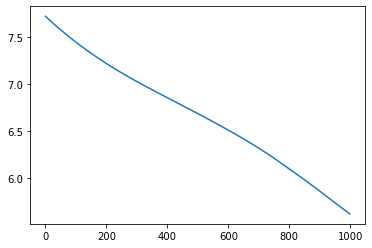

In [8]:
er_bp = erisk(Xt, Y, ffnn1, loss_func_sq)
fg_bp = erm_fg(er_bp, h=0.001, tol=1.0e-8, n_iter=1000, n_restart=5)

plt.plot(fg_bp.lvals)
plt.show()

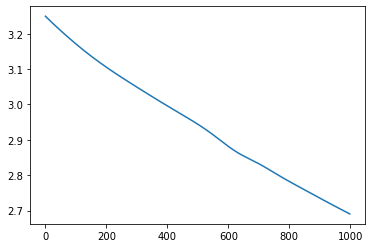

In [9]:
er_sqrt = erisk(Xt, Y, ffnn2, loss_func_sqrt)
fg_sqrt = erm_fg(er_sqrt, h=0.001, tol=1.0e-8, n_iter=1000, n_restart=5)

plt.plot(fg_sqrt.lvals)
plt.show()

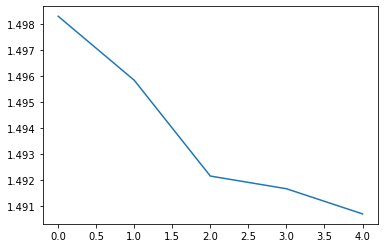

In [22]:
er_wm = erisk(Xt, Y, ffnn3, loss_func_sqrt)
fg_wm = fg(er_wm, h=0.001, tol=1.0e-8, n_iter=1000)
avg_wm = averager_it(func.QuantileFunc(0.90, func.Sqrt(1)))
wg_wm = weights.WMWeights(avg_wm, er_wm)
irgd_wm = erm_irgd(fg_wm, wg_wm, n_iter=22)

plt.plot(irgd_wm.lvals)
plt.show()

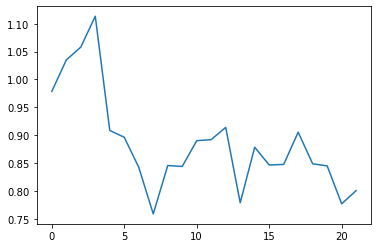

In [27]:
er_m = erisk(Xt, Y, ffnn4, loss_func_sq)
fg_m = fg(er_m, h=0.001, tol=1.0e-8, n_iter=1000)
avg_m = averager_it(func.QuantileFunc(0.90, func.Sqrt(1)))
avg_m = avragg.MHAverage(avg_m)
wg_m = weights.MWeights(avg_m, er_m)
irgd_m = erm_irgd(fg_m, wg_m, n_iter=22)

plt.plot(irgd_m.lvals)
plt.show()

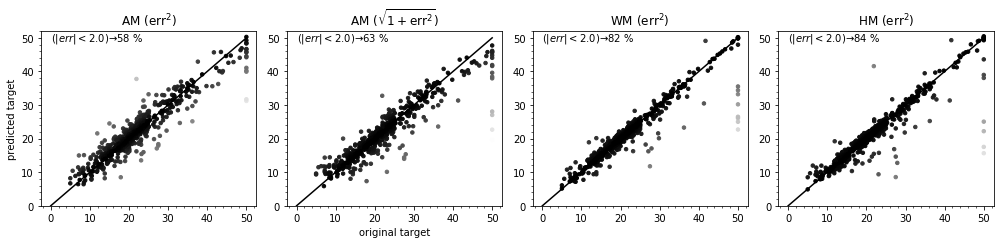

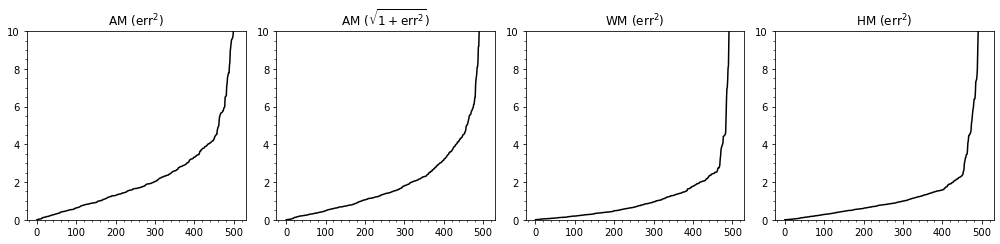

In [28]:
b = 2.0
Yp1 = np.array([ffnn1(x) for x in Xt])
Yp2 = np.array([ffnn2(x) for x in Xt])
Yp3 = np.array([ffnn3(x) for x in Xt])
Yp4 = np.array([ffnn4(x) for x in Xt])
data = [
    { 'Y':Yp1, 'title':'AM ($\mathrm{err}^2$)' },
    { 'Y':Yp2, 'title':'AM ($\sqrt{1+\mathrm{err}^2}$)' },
    { 'Y':Yp3, 'title':'WM ($\mathrm{err}^2$)'},
    { 'Y':Yp4, 'title':'HM ($\mathrm{err}^2$)' },
]
plt.figure(figsize=(len(data)*3.5, 3.5))
for i, d in enumerate(data):
    Y1 = d['Y']
    title = d['title'] 
    plt.subplot(1, 4, i+1)
    plt.title(title)
    V = np.abs(Y-Y1)
    I = np.argsort(V)
    I = I[::-1]
    plt.scatter(Y[I], Y1[I], c=V[I], s=12, cmap=plt.cm.gray)
    c = sum(V < b) / len(V) * 100
    plt.text(0, 49, r'$(|err|<%.1f)\to%s$ %%' % (b, int(c)))
    plt.plot([0,50],[0,50], c='k')
    if i == 1:
        plt.xlabel("original target")
    if i == 0:
        plt.ylabel("predicted target")
    plt.ylim(0, 52)
    plt.minorticks_on()
plt.savefig(r"fig/isnn2019_boston_%s_%s.eps" % (n_hidden1, n_hidden2))
plt.tight_layout()
plt.show()

plt.figure(figsize=(len(data)*3.5, 3.5))
for i, d in enumerate(data):
    Y1 = d['Y']
    title = d['title'] 
    plt.subplot(1, 4, i+1)
    plt.title(title)
    V = np.abs(Y-Y1)
    Vs = np.sort(V)
    plt.plot(Vs, c='k')
    plt.ylim(0,10)
    plt.minorticks_on()
#plt.savefig(r"fig/isnn2019_boston_%s.pdf" % n_hidden)
plt.tight_layout()
plt.show()

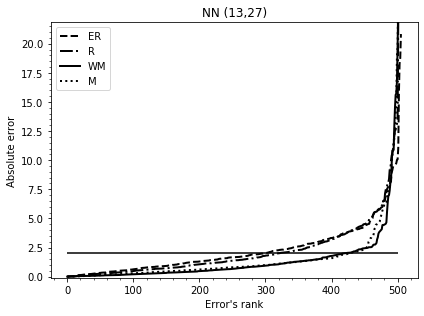

In [29]:
plt.figure(figsize=(6,4.5))
plt.title('NN (%s,%s)' % (n_hidden1, n_hidden2))
Z = np.abs(Yp1-Y)
Z2 = np.abs(Yp2-Y)
Z3 = np.abs(Yp3-Y)
Z4 = np.abs(Yp4-Y)
plt.plot(sorted(Z), label='ER', color='k', linestyle='--', linewidth=2.0)
plt.plot(sorted(Z2), label='R', color='k', linestyle='-.', linewidth=2.0)
plt.plot(sorted(Z3), label='WM', color='k', linestyle='-', linewidth=2.0)
plt.plot(sorted(Z4), label='M', color='k', linestyle=':', linewidth=2.0)
plt.hlines(2.0, 0, 500)
plt.legend()
plt.ylim(-0.1, np.max(Z)+1)
plt.savefig(r"fig/nn_boston_1_%s_%s_%s.pdf" % (n_hidden1, n_hidden2, n_hidden3))
plt.minorticks_on()
plt.xlabel("Error's rank")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.show()

In [14]:
# plt.figure(figsize=(8,6))
# plt.plot(sorted(np.abs(Yp-Y)), label='BP', color='k', linestyle='--', linewidth=2.5)
# plt.plot(sorted(np.abs(Yp3-Y)), label='M-BP', color='k', linestyle='-', linewidth=2.5)
# #plt.plot(np.sort(np.abs(Yp3-Y)), label='M')
# plt.legend()
# #plt.ylim(-0.3, 6.)
# plt.savefig("fig/nn_boston_4.pdf")
# plt.show()